# Setup for a Causal Analysis of *How is the implementation of existing strategies affecting the rates of COVID-19 infection?*

*(Better displayed in [nbviewer](https://nbviewer.jupyter.org/) as red warning in font tag may not be displayed on github)*

We believe that a question such as *How is the implementation of existing strategies affecting the rates of COVID-19 infection?* requires a proper causal analysis of the data.

Such question requires considering what the *causal effect* of certain strategies may be, and an evaluation of *counterfactual effects*.

To answer this question we rely on the formalism of [*causal models*](http://bayes.cs.ucla.edu/BOOK-2K/) and the [*dowhy*](https://github.com/microsoft/dowhy) library.


### Disclaimer
In this notebook we setup a <font color='red'>**preliminary template**</font> for a causal analysis of this question. In particular, we setup a simple model that tries to estimate the **average causal effect** of a chosen policy.

<font color='red'>**This is a work in progress.**</font> Publishing this notebook has the sole aim to share an initial analysis and draws suggestions and critiques for improvement.

In no way, at the moment, these results should be taken to be significant. The data considered are limited, the model simplistic and debatable. <font color='red'>**NO conclusions on real world policies should be drawn from this notebook**</font>. 

Limitations will be highlighted in the notebook in RED (coloured fonts may not be displayed on github).

### Importing libraries

In [1]:
import numpy as np
import pandas as pd
import dowhy as dy

## 1. Data Part
In this part we collect the data that will be used in the analysis.

We will take into consideration four *variables* for different countries over different days:
- *deaths*: number of reported deaths from covid19
- *confirmed*: number of confirmed cases of infection from covid19
- *treatment*/*measure*/*policy*: the implementation of a specific policy
- *hospital beds*: number of hospital beds for 1000 citizens

<font color='red'>**The selection of these variables is arbitrary and should be enriched.**</font>.

### Loading data

We will use three data sets:
- **HDE**/HDE/acaps-covid-19-government-measures-dataset: this dataset provides information on the adoption of different measures to contain covid19.
- **johns_hopkins**/johns-hopkins-covid-19-daily-dashboard-cases-over-time: this dataset provides information on the effects of covid19.
- **world_bank**/: these datasets provide background information about a country.

In [2]:
HDE_df = pd.read_csv('HDE/acaps-covid-19-government-measures-dataset.csv')
JHU_df = pd.read_csv('johns_hopkins/johns-hopkins-covid-19-daily-dashboard-cases-over-time.csv')
WB_df = pd.read_csv('world_bank/hospital-beds-per-1-000-people.csv')

### Finding the common countries

We perform a little bit of manual alignment on the countries contained in the two datasets.

<font color='red'>**This alignment is incomplete**</font>

In [3]:
def replace_HDE(original,replacement):
    HDE_df.loc[HDE_df['country']==original, 'country'] = replacement

replace_HDE('United States of America','US')
replace_HDE('Czech Republic','Czechia')
replace_HDE('Korea Republic of','Korea, South')
replace_HDE('North Macedonia Republic Of','North Macedonia') 
replace_HDE('kenya','Kenya') 
replace_HDE('Viet Nam','Vietnam') 
replace_HDE('Russian Federation','Russia') 

In [4]:
countriesHDE = set(HDE_df['country'].unique())
countriesJHU = set(JHU_df['country_region'].unique())
countries = list(countriesHDE.intersection(countriesJHU))

### Finding the date range

We convert the dates in the HDE dataset in datetimes, and we extract the range of dates from the JHU dataset.

<font color='red'>**Some dates in the HDE dataset are inconsistent** (hence the *errors='coerce'* option)</font>

<font color='red'>**We rely on the JHU providing the same range of data for all countries**</font>

In [5]:
HDE_df['date_implemented'] = pd.to_datetime(HDE_df['date_implemented'],format="%m-%d-%y",errors='coerce')

dates = JHU_df.loc[JHU_df['country_region']==countries[0],'last_update'].values

### Defining the measure/policy of interest

We define a measure/policy of interest, which will be *treatment* of interest in the causal analysis. Use *list(HDE_df['measure'].unique())* to list the 32 measures tracked in the HDE dataset.

In [6]:
treatment = 'Introduction of quarantine policies'

### Creating a new dataframe

We create a new dataframe, cast the dates in datetime, and add a new binary column that will track when the chosen policy of interest is activated.

In [7]:
df = JHU_df.copy()
df['last_update'] = pd.to_datetime(df['last_update'])
df[treatment] = 0

We set the new column/field as active (=1) from the day **after** the policy has been called for by a government.

In [8]:
ncountries_treatment = 0
for i in countries:
    try:
        activationdate = HDE_df.loc[(HDE_df['country']==i) & (HDE_df['measure']==treatment), 'date_implemented'].values[0]
        df.loc[(df['country_region']==i) & (df['last_update'] > activationdate), treatment ] = 1
        ncountries_treatment += 1
    except IndexError:
        print('Country {0} has not implemented policy {1} to date {2}'.format(i,treatment,dates[-1]))
        
print('\n{0} countries have implemented policy {1} to date {2}'.format(ncountries_treatment,treatment,dates[-1]))

Country Switzerland has not implemented policy Introduction of quarantine policies to date 2020-03-30
Country Djibouti has not implemented policy Introduction of quarantine policies to date 2020-03-30
Country Bhutan has not implemented policy Introduction of quarantine policies to date 2020-03-30
Country Trinidad and Tobago has not implemented policy Introduction of quarantine policies to date 2020-03-30
Country US has not implemented policy Introduction of quarantine policies to date 2020-03-30
Country Rwanda has not implemented policy Introduction of quarantine policies to date 2020-03-30
Country Mongolia has not implemented policy Introduction of quarantine policies to date 2020-03-30
Country Libya has not implemented policy Introduction of quarantine policies to date 2020-03-30
Country Tanzania has not implemented policy Introduction of quarantine policies to date 2020-03-30
Country Pakistan has not implemented policy Introduction of quarantine policies to date 2020-03-30
Country B

### Retrieving further data
We extract more background information, specifically considering what could be *confounders* between our treatment and effect.
In this notebook we take the last recorded value of *hospital beds per 1000 people* from the *world_bank* data set.

In [9]:
ncountries_confounder = 0

confounder = 'hospital beds'
df[confounder] = np.nan
for i in countries:
    df1 = WB_df.loc[WB_df['country_name']==i]
    beds_nan = df1.iloc[:,4:].values
    try:
        beds = beds_nan[np.isfinite(beds_nan)][-1]
        df.loc[(df['country_region']==i), confounder] = beds
        ncountries_confounder += 1
    except:
        print('Country {0} has no reported {1} between 1960-2019'.format(i,confounder))
        
print('\n{0} countries have reported {1} between 1960-2019'.format(ncountries_confounder,confounder))

Country Egypt has no reported hospital beds between 1960-2019
Country Saint Lucia has no reported hospital beds between 1960-2019
Country US has no reported hospital beds between 1960-2019
Country Bahamas has no reported hospital beds between 1960-2019
Country Kyrgyzstan has no reported hospital beds between 1960-2019
Country Syria has no reported hospital beds between 1960-2019
Country Korea, South has no reported hospital beds between 1960-2019
Country Venezuela has no reported hospital beds between 1960-2019
Country Iran has no reported hospital beds between 1960-2019
Country Czechia has no reported hospital beds between 1960-2019
Country Saint Vincent and the Grenadines has no reported hospital beds between 1960-2019
Country Russia has no reported hospital beds between 1960-2019
Country Slovakia has no reported hospital beds between 1960-2019
Country Liechtenstein has no reported hospital beds between 1960-2019
Country Gambia has no reported hospital beds between 1960-2019

146 cou

### Conclusion

In this part we collected data that we will be fed in our model.

<font color='red'>**Richer and more relevant data should be collected**</font>

## 2. Model Part
In this section we rely on the *dowhy* library to build a causal model.

<font color='red'>**This sort of data implicitly requires a time-dependent analysis, but we will analyze data statically on a per-day basis.**</font>

## Preparing the data for the causal model
We extract the data that is relevant for our analysis and we drop lines containing *nan*.

<font color='red'>**Missing values may be dealt better than just dropping**</font>

In [10]:
data = pd.DataFrame(data=
                    {'confirmed': df['confirmed'],
                     'deaths': df['confirmed'],
                     'hospital beds': df[confounder],
                     'Introduction of quarantine policies': df[treatment].astype('bool'),
                     }
                   )
rows1 = data.shape[0]
data = data.dropna()
print('Dropped {0} rows with nan values'.format(rows1 - data.shape[0]))

Dropped 2208 rows with nan values


### Setting up a Causal Model

We now set up a causal model as illustrated by the graph below.

In [11]:
model= dy.CausalModel(
    data = data,
    treatment = treatment,
    outcome = 'deaths',
    graph = """graph[directed 1 node[id "confirmed" label "confirmed"]
                node[id "deaths" label "deaths"]
                node[id "Introduction of quarantine policies" label "Introduction of quarantine policies"]
                node[id "hospital beds" label "hospital beds"]
                edge[source "confirmed" target "deaths"]
                edge[source "hospital beds" target "deaths"]
                edge[source "Introduction of quarantine policies" target "deaths"]
                edge[source "hospital beds" target "Introduction of quarantine policies"]
                edge[source "Introduction of quarantine policies" target "confirmed"]]
    """)

INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['Introduction of quarantine policies'] on outcome ['deaths']


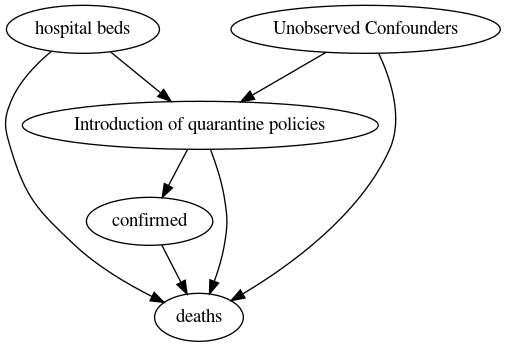

In [12]:
from IPython.display import Image, display
model.view_model()
display(Image(filename="causal_model.png"))

This causal model is arbitrary, and proposed mainly as an example.

We asssume that the number of deaths is influenced by the number of already confirmed cases, the availability of hospital beds (the number of beds is taken as a proxy measure of the availability and quality of healthcare), by adoption of the policy, and other unobserved confounder; the number of confirmed cases is taken to depend on the adoption of the chosen policy; the introduction of the chosen policy is affected again by the quality of healthcare expressed by the number of beds pro capite and by other unobserved confounders.

We take as **outcome** variable the number of deaths, as **treatment** variable the specific policy under study, as **confounder** the number of hospital beds (plus potentially unobserved confounders). The number of confirmed cases constitutes a **mediator**.

This model will allow us to answer (<font color='red'>within this model</font>) the question: *What is the effect of the chosen policy on the number of deaths caused by covid19?*

Several questions may be asked about the meaningfulness of this model: does the choice of number of beds make sense as a confounder? Is the number of deaths affected only the mediator of confirmed cases? Is this model complete at all? These are valid questions, but we do not provide an answer as we lack domain knowledge. Instead we will study this model to provide an example of such analysis.

<font color='red'>**Proper modelling, using knowledge from epidemiology and sociology, should be done here.**</font>

## 3. Analysis

We now go through the standard steps of causal analysis (after modelling): (i) *identification*, (ii) *estimation*, and (iii) *refutation*.

### Identification

We evaluate the identifiability of the causal effect, that is whether we can evalute the causal effect of the policy under consideration on the outcome given the model we have specified.

In [13]:
identified_estimand = model.identify_effect()

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['U', 'hospital beds']


WARN: Do you want to continue by ignoring any unobserved confounders? (use proceed_when_unidentifiable=True to disable this prompt) [y/n] y


INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]


Notice that *dowhy* warns us about the presence of unobserved confounders that may affect our analysis. We go on with this analysis even if we are obviously aware of the fact that our simple model ignores many confounders.

<font color='red'>**Proper modelling, using knowledge from epidemiology and sociology, is necessary to identify confounders.**</font>

In [14]:
print(identified_estimand)

Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
                  d                                                      
──────────────────────────────────────(Expectation(deaths|hospital beds))
d[Introduction of quarantine policies]                                   
Estimand assumption 1, Unconfoundedness: If U→{Introduction of quarantine policies} and U→deaths then P(deaths|Introduction of quarantine policies,hospital beds,U) = P(deaths|Introduction of quarantine policies,hospital beds)
### Estimand : 2
Estimand name: iv
No such variable found!



*dowhy* allowed us to discover an estimand based on the *backdoor* criterion to assess the causal effect of the treatment on the outcome; notice that *dowhy* reminds us that this estimand is based on an *unconfoundedness* assumption.

### Estimation

We run three methods for the estimation of the causal effect: a *propensity score matching* (by default, *dowhy* uses LogisticRegression for computing propensity scores and k-NN (k=1) to find a match), *propensity score stratification* (by default, *dowhy* sets up 50 clipped strata), and *inverse probability weighting*.

In [21]:
estimate = model.estimate_effect(identified_estimand, method_name="backdoor.propensity_score_matching")
print(estimate)

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: deaths~Introduction of quarantine policies+hospital beds
/home/fmzennaro/miniconda2_1/envs/covid/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


*** Causal Estimate ***

## Target estimand
Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
                  d                                                      
──────────────────────────────────────(Expectation(deaths|hospital beds))
d[Introduction of quarantine policies]                                   
Estimand assumption 1, Unconfoundedness: If U→{Introduction of quarantine policies} and U→deaths then P(deaths|Introduction of quarantine policies,hospital beds,U) = P(deaths|Introduction of quarantine policies,hospital beds)
### Estimand : 2
Estimand name: iv
No such variable found!

## Realized estimand
b: deaths~Introduction of quarantine policies+hospital beds
## Estimate
Value: 401.1329164185031



In [22]:
estimate = model.estimate_effect(identified_estimand, method_name="backdoor.propensity_score_stratification")
print(estimate)

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: deaths~Introduction of quarantine policies+hospital beds
/home/fmzennaro/miniconda2_1/envs/covid/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


*** Causal Estimate ***

## Target estimand
Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
                  d                                                      
──────────────────────────────────────(Expectation(deaths|hospital beds))
d[Introduction of quarantine policies]                                   
Estimand assumption 1, Unconfoundedness: If U→{Introduction of quarantine policies} and U→deaths then P(deaths|Introduction of quarantine policies,hospital beds,U) = P(deaths|Introduction of quarantine policies,hospital beds)
### Estimand : 2
Estimand name: iv
No such variable found!

## Realized estimand
b: deaths~Introduction of quarantine policies+hospital beds
## Estimate
Value: 1667.7588405151612



In [20]:
estimate = model.estimate_effect(identified_estimand, method_name="backdoor.propensity_score_weighting", method_params={"weighting_scheme":"ips_weight"})
print(estimate)

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: deaths~Introduction of quarantine policies+hospital beds


*** Causal Estimate ***

## Target estimand
Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
                  d                                                      
──────────────────────────────────────(Expectation(deaths|hospital beds))
d[Introduction of quarantine policies]                                   
Estimand assumption 1, Unconfoundedness: If U→{Introduction of quarantine policies} and U→deaths then P(deaths|Introduction of quarantine policies,hospital beds,U) = P(deaths|Introduction of quarantine policies,hospital beds)
### Estimand : 2
Estimand name: iv
No such variable found!

## Realized estimand
b: deaths~Introduction of quarantine policies+hospital beds
## Estimate
Value: 1440.5259837012877



/home/fmzennaro/miniconda2_1/envs/covid/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


All the models seems to agree on a strong effect of the treatment on the outcome, although in the opposite way we would expect. This outcome is reasonable given our simple model and limited data: the data cover only a limited span of time; very likely the number of deaths is following its trend and the introduction of a policy like a quarantine which has a delayed effect was not registered in the data. Again, this should remark the current <font color='red'>**NON-relevance**</font> of this preliminary results.

### Refutation

A last step in a rigorous causal analysis would be a refutation step. Our model is just a dummy model, so we are not really taking its conclusions in consideration. However we present the formal refutation procedure provided by *dowhy*.

We run a refutation process based on shuffling the values of our treatment; if the treatment had a real causal effect the estimate average treatment effect is expected to drop to 0.

In [46]:
from dowhy.causal_refuters.placebo_treatment_refuter import PlaceboTreatmentRefuter
refuter = PlaceboTreatmentRefuter(data=data, identified_estimand=identified_estimand, estimate=estimate, placebo_type='permute')
print(refuter.refute_estimate())

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: deaths~placebo+hospital beds
/home/fmzennaro/miniconda2_1/envs/covid/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Refute: Use a Placebo Treatment
Estimated effect:(1667.7588405151612,)
New effect:(26.190793359377157,)



## 4. Further work

This notebook has presented an outline for a static causal analysis of covid19 data. However this draft is far from being complete:

- <font color='red'>**Proper modelling and inclusion of meaningful and relevant variables is essential.**</font>
- <font color='red'>**Validation of standard causal hypothesis and assumptions is required.**</font>
- <font color='red'>**A time-dependent model would be in order to process this scenario.**</font>